PREDICT THE AVERAGE ACTIVE POWER FOR THE NEXT 15 DAYS.

## Data Dictionarity

- Unnamed: 0: Timestamp sampled with period interval of 10 minutes.
- ActivePower: Active power generated by the windmill.
- AmbientTemperatue: Ambient temperature.
- BearingShaftTemperature: Bearing shaft temperature of the motor.
- Blade1PitchAngle: pitch angle of the wind turbine blade 1.
- Blade2PitchAngle: pitch angle of the wind turbine blade 2.
- Blade3PitchAngle: pitch angle of the wind turbine blade 3.
- ControlBoxTemperature: temperature of wind turbine control.
- GearboxBearingTemperature: Gearbox Bearing Temperature of the motor.
- GearboxOilTemperature: Gearbox Oil Temperature of the motor.
- GeneratorRPM: Measured RPM of the generator.
- GeneratorWinding1Temperature: Temperature of the winding in the generator 1.
- GeneratorWinding2Temperature: Temperature of the winding in the generator 2.
- HubTemperature: Temperature of Hub computer that control pitching of blades.
- MainBoxTemperature: Temperature of main box.
- NacellePosition: Position of the nacelle.
- ReactivePower: Reactive power generated by the windmill.
- RotorRPM: RPM of the rotor.
- TurbineStatus: Status of the turbine.
- WTG: Indicates that mechanical energy is instead converted to electricity, only G01.
- WindDirection: Wind direction in degrees. 
- WindSpeed: Wind speed in km/h.


## 0.0 Imports

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from IPython.display import Image

### 0.1 Helper Functions

In [3]:
# Function that converts camel style to snake style
def camel_to_snake(s):
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [4]:
# Function that calculate  the descriptive statistics
def descriptive_analysis(numerical_df):
    # Function that calculate all the statistics measures for the dataset
    # Central tendency - Mean, median
    ct1 = pd.DataFrame(numerical_df.apply(np.mean)).T
    ct2 = pd.DataFrame(numerical_df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(numerical_df.apply(np.std)).T
    d2 = pd.DataFrame(numerical_df.apply(min)).T
    d3 = pd.DataFrame(numerical_df.apply(max)).T
    d4 = pd.DataFrame(numerical_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(numerical_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(numerical_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
    m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

    return m

In [5]:
# Function that put the information of values inside the graphic
def label_graph(ax, fmt):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), fmt), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

In [6]:
def find_outliers(df, col_name):
    # Calculates Q1, Q3 and IQR
    Q1 = np.quantile(df[col_name], 0.25)
    Q3 = np.quantile(df[col_name], 0.75)
    IQR = Q3 - Q1

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = Q1 - 1.5 * IQR
    high_outliers = Q3 + 1.5 * IQR

    print('Outliers limit for {}:'.format(col_name))
    print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")
    
    return low_outliers, high_outliers

In [127]:
# Function to calculate MAE
def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)
# Function to calculate MAPE
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))
# Function that calculates MAE, MAPE and RMSE
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index=[0])

In [210]:
# Function to train the model using cross validation
def cross_validation(x_training, selected_features, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # Date that will start the validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7)

        # Filter the dataset and split it in train and test
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Drop columns for training
        xtraining = training[selected_features]
        ytraining = training['active_power']

        # Drop columns for validation
        xvalidation = validation[selected_features]
        yvalidation = validation['active_power']

        # ML Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error( 'Linear regression', np.expm1(yvalidation) -1 + yvalidation.min(),  np.expm1(yhat) -1 +  yhat.min())
    
        # Performance for each metric
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( { 'Model': [model_name],
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index = [0])

### 0.2 Loading Data

In [7]:
df0 = pd.read_csv('../data/Turbine_Data.csv')

In [8]:
df0.head()

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN


## 1.0 Data Description

Describing data is important in this section for better comprehension of the dataset. Also, by using Descriptive Statistics,  it is possible to describe data through methods such as graphical representations, measures of central tendency and measures of variability. It summarizes the data in a meaningful way which enables us to generate insights from it.

In [9]:
df1 = df0.copy()

### 1.1 Rename Columns

In [10]:
# Rename timestamp column 
df1 = df1.rename(columns={'Unnamed: 0': 'Date'})

In [11]:
# Convert the camel case to snake case
cols_old = ['Date', 'ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature','Blade1PitchAngle', 'Blade2PitchAngle', 
            'Blade3PitchAngle', 'ControlBoxTemperature', 'GearboxBearingTemperature','GearboxOilTemperature', 
            'GeneratorRPM', 'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature', 'HubTemperature',
            'MainBoxTemperature','NacellePosition', 'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG',
            'WindDirection', 'WindSpeed']

snake_case = lambda x: camel_to_snake(x)

cols_new = list(map(snake_case, cols_old))

df1.columns = cols_new

# Correction after snake transformation
cols_to_correct = ['generator_r_p_m', 'rotor_r_p_m', 'w_t_g']
cols_corrected = ['generator_rpm', 'rotor_rpm', 'wtg']

df1 = df1.rename(columns={'generator_r_p_m': 'generator_rpm',
                         'rotor_r_p_m': 'rotor_rpm',
                         'w_t_g': 'wtg'})

### 1.2 Data Dimensions

In [12]:
# Print the number of examples and features
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 118224
Number of columns: 22


### 1.3 Data Types

In [13]:
# Show the type of each column
df1.dtypes

date                               object
active_power                      float64
ambient_temperatue                float64
bearing_shaft_temperature         float64
blade1_pitch_angle                float64
blade2_pitch_angle                float64
blade3_pitch_angle                float64
control_box_temperature           float64
gearbox_bearing_temperature       float64
gearbox_oil_temperature           float64
generator_rpm                     float64
generator_winding1_temperature    float64
generator_winding2_temperature    float64
hub_temperature                   float64
main_box_temperature              float64
nacelle_position                  float64
reactive_power                    float64
rotor_rpm                         float64
turbine_status                    float64
wtg                                object
wind_direction                    float64
wind_speed                        float64
dtype: object

**Observations**:
- date is a object and not datetime.

In [14]:
# Convert date column from string to datetime
df1['date'] = pd.to_datetime(df1['date'])

### 1.4 Checking Missing Values

In [15]:
# Shows the percentage of missing values
100* df1.isna().sum() / len(df1)

date                               0.000000
active_power                      19.855528
ambient_temperatue                20.644708
bearing_shaft_temperature         47.119028
blade1_pitch_angle                64.477602
blade2_pitch_angle                64.566416
blade3_pitch_angle                64.566416
control_box_temperature           47.421843
gearbox_bearing_temperature       47.100420
gearbox_oil_temperature           47.186696
generator_rpm                     47.307653
generator_winding1_temperature    47.196001
generator_winding2_temperature    47.177392
hub_temperature                   47.213764
main_box_temperature              47.128333
nacelle_position                  38.863513
reactive_power                    19.857220
rotor_rpm                         47.449756
turbine_status                    46.789146
wtg                                0.000000
wind_direction                    38.863513
wind_speed                        19.986636
dtype: float64

**Observations**:
- It was found a large number of missing values, representing 64.56% of the dataset in some features;
- There are some strategies that we can handle: Drop the columns with expressive missing values; Replace it by the mean/median; Moving average; Replace with the last or next value non-null.
- For this problem, I am going to use the method ffill and bfill from pandas, which propagates the last non-null value in backward and forward direction.


### 1.5 Replace NaN values

In [16]:
# Replace NaN values by propagating forward and backward the last value non-null
df1 = df1.fillna(method='ffill').fillna(method='bfill')

In [17]:
# Shows the percentage of missing values
100* df1.isna().sum() / len(df1)

date                              0.0
active_power                      0.0
ambient_temperatue                0.0
bearing_shaft_temperature         0.0
blade1_pitch_angle                0.0
blade2_pitch_angle                0.0
blade3_pitch_angle                0.0
control_box_temperature           0.0
gearbox_bearing_temperature       0.0
gearbox_oil_temperature           0.0
generator_rpm                     0.0
generator_winding1_temperature    0.0
generator_winding2_temperature    0.0
hub_temperature                   0.0
main_box_temperature              0.0
nacelle_position                  0.0
reactive_power                    0.0
rotor_rpm                         0.0
turbine_status                    0.0
wtg                               0.0
wind_direction                    0.0
wind_speed                        0.0
dtype: float64

### 1.6 Descriptive Statistics

In [18]:
# Split the dataset in numerical and categorical
num_attributes = df1.select_dtypes(include = ['float64'])
cat_attributes = df1.select_dtypes(exclude = ['float64', 'datetime64[ns]'])

#### 1.6.1 Numerical Attributes

In [19]:
# Calculate the statistics
descriptive_analysis(num_attributes)

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,active_power,639.934548,423.445880,630.141658,-38.524659,1.779032e+03,1.817557e+03,0.648454,-1.082583
1,ambient_temperatue,28.574250,28.126315,4.308102,0.000000,4.240560e+01,4.240560e+01,0.281966,0.811206
2,bearing_shaft_temperature,44.966830,47.901936,6.404004,0.000000,5.508866e+01,5.508866e+01,-3.534934,20.653067
3,blade1_pitch_angle,31.797893,45.736893,22.150311,-43.156734,9.014361e+01,1.333003e+02,-0.436169,-0.989127
4,blade2_pitch_angle,30.718228,43.699357,21.173457,-26.443415,9.001783e+01,1.164612e+02,-0.366678,-0.828616
5,blade3_pitch_angle,30.718228,43.699357,21.173457,-26.443415,9.001783e+01,1.164612e+02,-0.366678,-0.828616
6,control_box_temperature,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
7,gearbox_bearing_temperature,68.885245,75.066281,11.675754,0.000000,8.223793e+01,8.223793e+01,-2.404865,9.730579
8,gearbox_oil_temperature,60.146597,63.304417,5.812920,0.000000,7.076458e+01,7.076458e+01,-1.396449,3.684245
9,generator_rpm,1359.868503,1691.274462,527.575804,0.000000,1.809942e+03,1.809942e+03,-1.351028,0.830080


**Observations**:

- **active_power** has an average of 639.93 KW and it reaches a maximum value of 1.78 MW. The variable has low skew and kurtosis, it may follow a normal distribution.
- **ambient_temperature** may follow a normal distribution and the average value is 28.56 ºC.
- **bearing_shaft_temperature** has a range of 55 ºC, and its average is 44.96 ºC.
- All the **blade** features are similar, in which the blade 1 vary a little bit more than the others.
- **control_box_temperature** has no information, all the values are zero.
- **gearbox_bearing_temperature** is skewed compared to the other variables, and this may not follow a normal distribution. The range is 82.2 ºC and the median 75.06 ºC.
- **gearbox_oil_temperature** may follow the same distribution of gear box bearing temperature. 
- The maximum value of **generator_rpm** is 1809 RPM, while its minimum is zero (when it is off). The median value is 1691 RPM.
- **generator_winding_temperature 1 and 2** are similar, they may not follow a normal distribution and the maximum values reach 1260 ºC, which can indicate an outlier. 
- **hub_temperature** reaches 47.96 ºC with an average of 38.7 ºC.
- **main_box_temperature** is very similar to the hub temperature, but it reaches 54.25 ºC.
- **nacelle_position** has a range of degrees from 0 to 357º, with a median of 188º and an average of 201.71º.
- **reactive_power** has a minimum value of -203.18 VAr, which indicates a moment that the load is more capacitive. When the reactive power is positive, it means a inductive load. Mostly values are positive, it indicates a inductive load.
- **rotor_rpm** is very low compared to the generator. The average value is 12.19 RPM.
- **wind_direction** also has a range from 0 to 357º and the average value is 201.71º. 
- **wind_speed** may follow a normal distribution and the average value is 6.03 km/h, reaching the maximum value of 22.9 km/h.

#### 1.6.2 Categorical Attributes

- Only WTG is a categorical attribute and has no information contained in the variable. I will treat it later.

## 2.0 Filtering Data

This section is used to drop some columns that were analyzed in the previous sections and does not contain any information. This may be useful to reduce the model complexity.

In [20]:
df2 = df1.copy()

### 2.1 Filtering Rows

In [21]:
cols_to_clean = ['active_power', 'ambient_temperatue', 'bearing_shaft_temperature', 'blade1_pitch_angle', 'blade2_pitch_angle', 'blade3_pitch_angle', 'gearbox_bearing_temperature', 'gearbox_oil_temperature', 'generator_rpm', 'generator_winding1_temperature', 'generator_winding2_temperature', 'hub_temperature', 'main_box_temperature', 'nacelle_position', 'reactive_power', 'rotor_rpm', 'turbine_status', 'wind_direction', 'wind_speed']
for col in cols_to_clean:
    low, high = find_outliers(df2, col)
    df2 = df2[(df2[col] >= low) & (df2[col] < high)]

Outliers limit for active_power:
Q1 = 70.59523496368422
Q3 = 1155.6266169649123
IQR = 1085.031382001228
low_outliers = -1556.9518380381578
high_outliers = 2783.173689966754
Outliers limit for ambient_temperatue:
Q1 = 25.5313385
Q3 = 31.261132142152263
IQR = 5.729793642152263
low_outliers = 16.936648036771608
high_outliers = 39.85582260538066
Outliers limit for bearing_shaft_temperature:
Q1 = 41.592835328571425
Q3 = 47.90193587500001
IQR = 6.309100546428581
low_outliers = 32.12918450892855
high_outliers = 57.36558669464288
Outliers limit for blade1_pitch_angle:
Q1 = 1.6585923473684212
Q3 = 45.7368925375
IQR = 44.07830019013158
low_outliers = -64.45885793782894
high_outliers = 111.85434282269736
Outliers limit for blade2_pitch_angle:
Q1 = 2.1403288375000002
Q3 = 43.69935714285714
IQR = 41.55902830535714
low_outliers = -60.198213620535704
high_outliers = 106.03789960089284
Outliers limit for blade3_pitch_angle:
Q1 = 2.1403288375000002
Q3 = 43.69935714285714
IQR = 41.55902830535714
low_out

### 2.1 Filtering Columns

In [22]:
cols_to_drop = ['wtg', 'control_box_temperature']

df2 = df2.drop(cols_to_drop, axis = 1)

## 3.0 Feature Engineering

Feature engineering involves leveraging data mining techniques to extract features from raw data along with the use of domain knowledge. Feature engineering is useful to improve the performance of machine learning algorithms and to better understand the dataset behaviour. Also, it is used a mind map with some hypothesis that can generate important insights to the engineer and answer the questions that were made in the beginning of the project.

In [23]:
df3 = df2.copy()

### 3.1 Hypothesis Mind Map

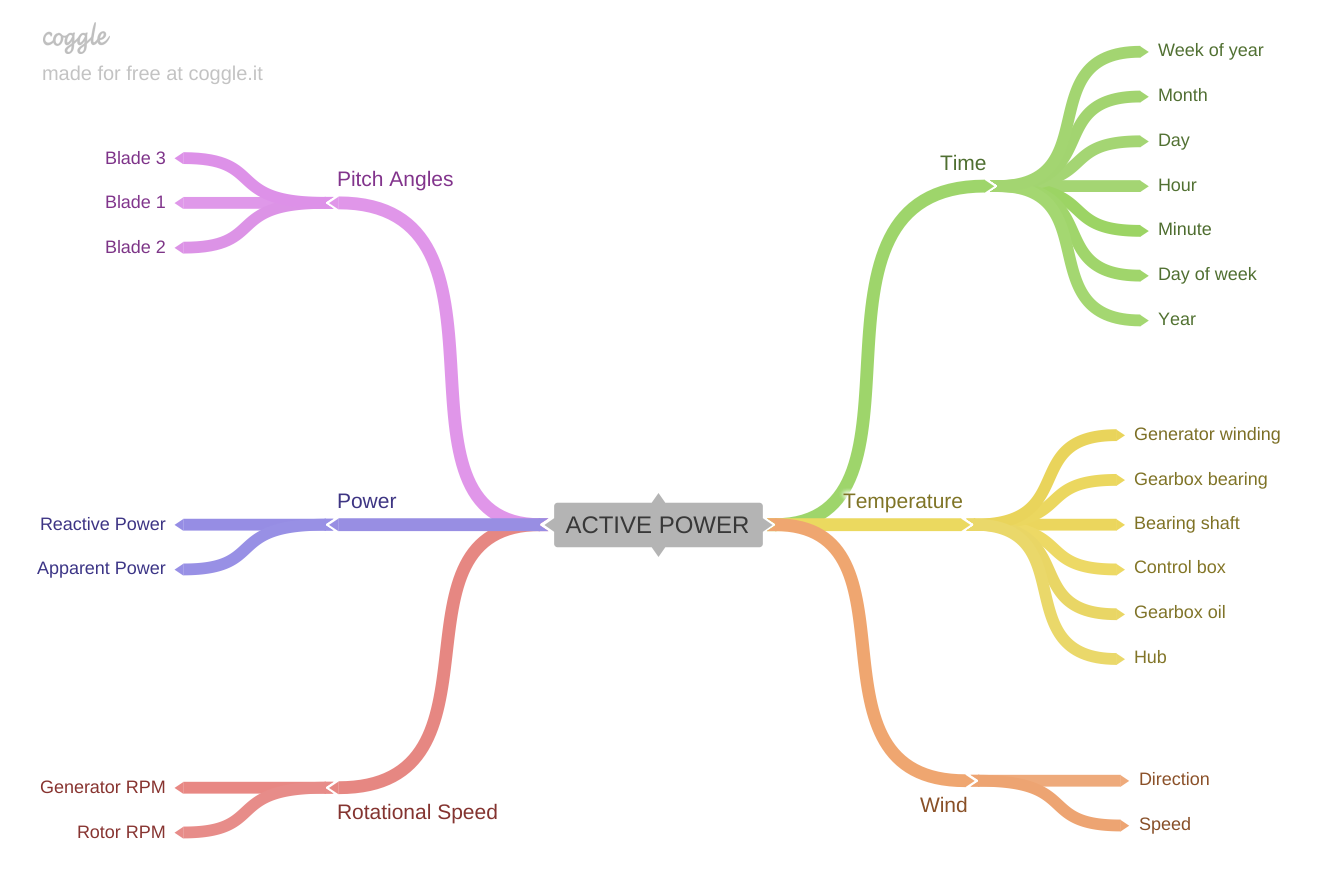

In [24]:
Image('../images/mind_map_hypothesis.png')

### 3.2 Hypothesis List

**H1** - From january to march, the windmill generates the largest active power.

**H2** - The active power produced in X and Y are similar.

**H3** - Higher the temperature of the gearbox bearing, higher the conversion to active power.

**H4** - Wind direction of 180º generates the highest value of active power.

**H5** - Higher the wind speed, higher the active power generation.

**H6** - Pitch angle between 0º and 30º is the optimal position for generate active power.

**H7** - Nacelle position misaligned with wind direction will generate less active power.

**H8** - Higher the Generator and Rotor RPM, higher the production of active power.

**H9** - The best hour for generation of power is in the night shift.

### 3.3 Creating New Features

In [25]:
# Extract Temporal Features
df3['day'] = df3['date'].dt.day
df3['minute'] = df3['date'].dt.minute
df3['hour'] = df3['date'].dt.hour
df3['day_of_week'] = df3['date'].dt.dayofweek
df3['day_of_year'] = df3['date'].dt.dayofyear
df3['week_of_year'] = df3['date'].dt.weekofyear
df3['month'] = df3['date'].dt.month
df3['year'] = df3['date'].dt.year

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  import sys


## 4.0 Exploratory Data Analysis (EDA)

This section is used to understand the business and the dataset. It is the most important part to report some useful insights for the managers. To analyze it, I will consider 3 analysis:

Univariate - The distribution, countplot and boxplot of each variable. It is important to remove outliers further.

Bivariate - All the hypothesis can be answered in this subsection. It can analyze the impact of each feature in the target variable;

Multivariate - Important to remove colinearity.

In [26]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#### 4.1.1 Target Variable

C:\Users\joaop\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


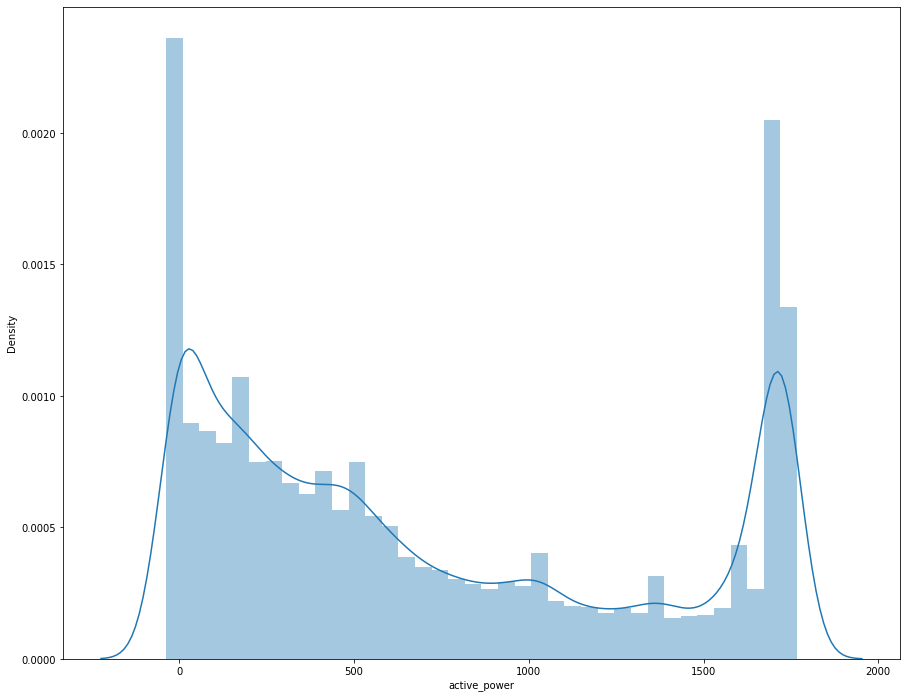

In [27]:
# Histogram of the  target variable
plt.figure(1, figsize=(15,12))
sns.distplot(df4['active_power'])

##### 4.4.1.1 Temporal Analysis

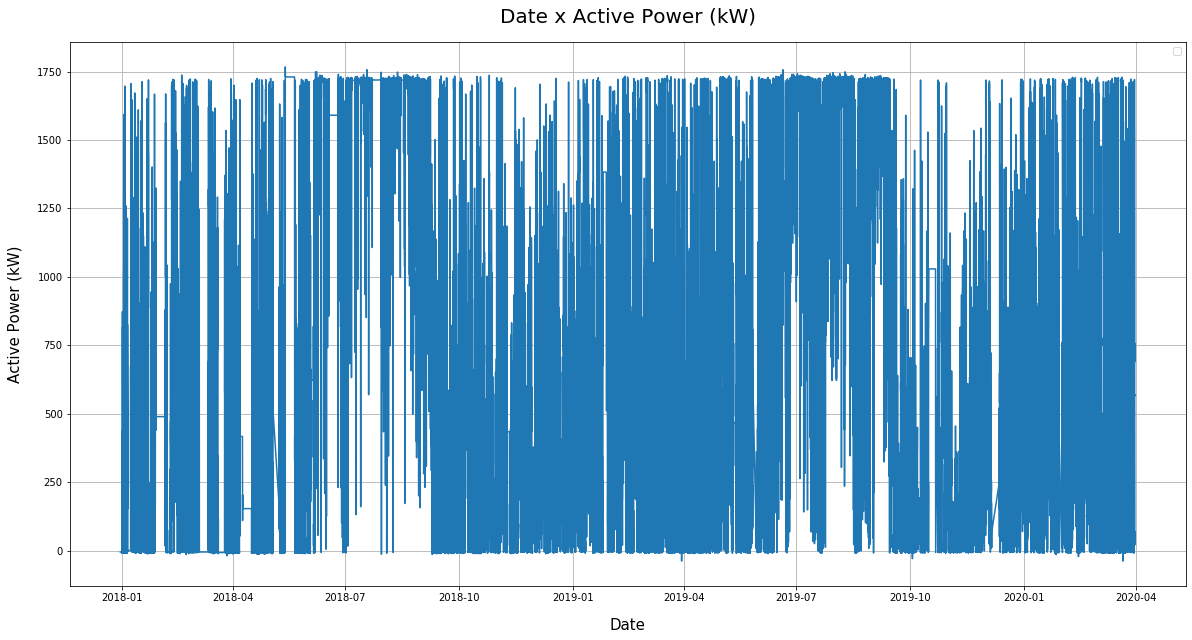

In [28]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Lineplot of active power 
ax = sns.lineplot(x = 'date', y = 'active_power', data = df4)

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Date x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Date", size= 15, labelpad= 15)
ax.legend('')
ax.grid()




Since it is a time-series problem, to forecast properly, we need to know if the time-series is stationary or not. For doing this, we are going to apply the Augmented Dickey-Fuller test. 


-Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

-Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

-p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

-p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [29]:
test_result = adfuller(df4['active_power'].values)

print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])

ADF Statistic: -15.364882
p-value: 0.000000


**Observations**:
- The target variable does not follow a normal distribution, it is depicted a bimodal behaviour.
- This may suggest the dataset is non-stationary.

#### 4.1.2 Numerical Attributes

In [30]:
num_attributes = df4.select_dtypes(include = ['float64'])

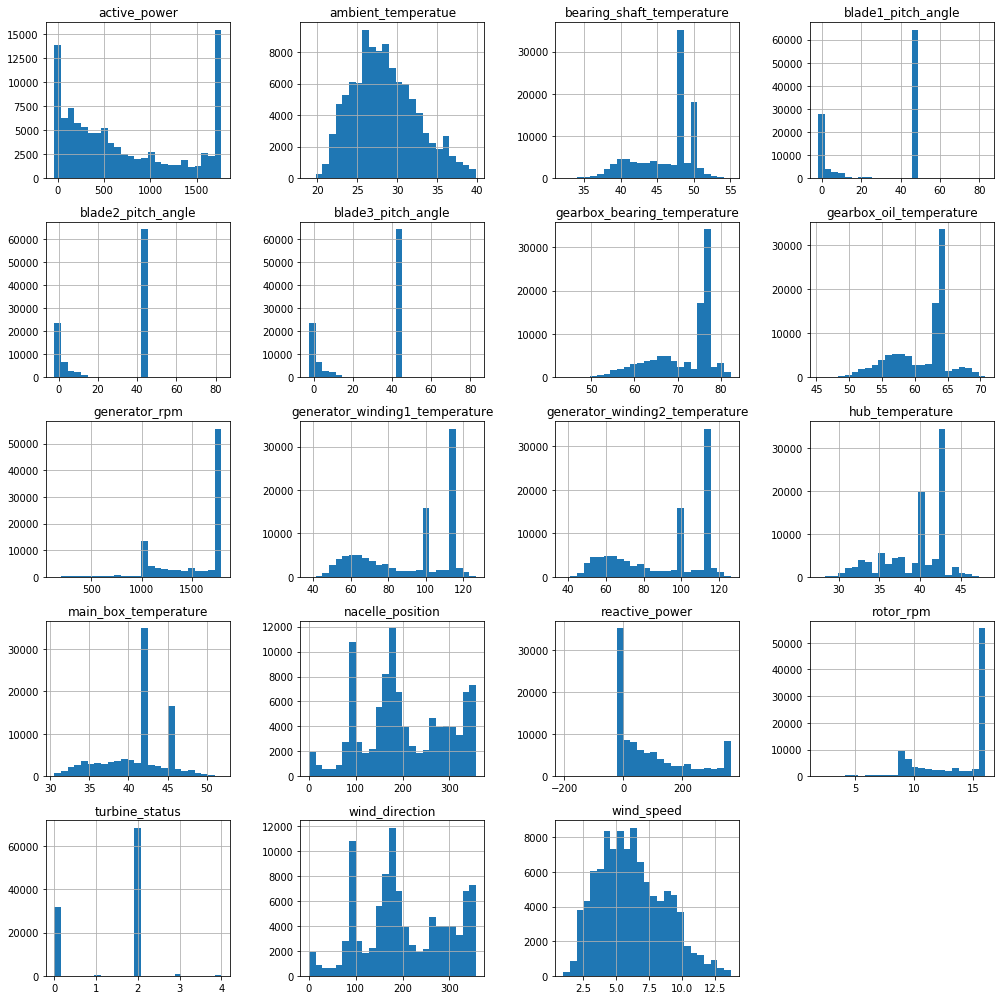

In [31]:
num_attributes.hist(bins = 25, figsize = (14,14))
plt.tight_layout()

TypeError: Horizontal orientation requires numeric `x` variable.

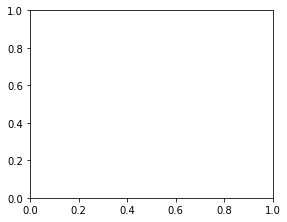

In [32]:
plt.figure(1, figsize = (20,20))
for i, col in enumerate(df1.columns):
    plt.subplot(5, 4, i+1)
    sns.boxplot(x = df1[col])

**Observations**:
- As seen above, most variables have more than a peak in the pdf;
- The outliers were filtred before by using IQR method.

### 4.2 Bivariate Analysis

**H1** - From january to march, the windmill generates the largest active power.


**FALSE**: The best months of the year for the power generation is between June and August.

In [ ]:
aux = df4.groupby('month')['active_power', 'wind_speed'].mean().reset_index()

In [ ]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Barplot of active power 
ax = sns.barplot(ax= ax, x= aux['month'], y= aux['active_power'])

label_graph(ax, '.1f')
# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Month", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Month", size= 15, labelpad= 15)
ax.grid()



In [ ]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Lineplot of active power 
ax = sns.lineplot(ax= ax, x= aux['month'], y= aux['active_power'])

sns.scatterplot(ax= ax, x= aux['month'], y= aux['active_power'], size= aux['wind_speed'], sizes= (1, 4000))

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Wind Speed x Month", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Month", size= 15, labelpad= 15)
ax.legend('')
ax.grid()




**H2** - The average active power produced in 2018, 2019 and are similar.



**FALSE**: The average of active power produced in 2018 is higher than 2019 and 2020. But, there are less registers in 2020.

In [ ]:
aux = df4.groupby('year')['active_power', 'wind_speed'].mean().reset_index()

In [ ]:
df4.groupby('year')['active_power', 'wind_speed'].count().reset_index()

In [ ]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Barplot of active power 
ax = sns.barplot(ax= ax, x= aux['year'], y= aux['active_power'])

label_graph(ax, '.1f')
# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Year", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Month", size= 15, labelpad= 15)
ax.grid()




In [ ]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Lineplot of active power 
ax = sns.lineplot(ax= ax, x= aux['year'], y= aux['active_power'])

#Scatterplot of Wind Speed with size based on the speed
sns.scatterplot(ax= ax, x= aux['year'], y= aux['active_power'], size= aux['wind_speed'], sizes= (1, 4000))

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Wind Speed x Year", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Month", size= 15, labelpad= 15)
ax.legend('')
ax.grid()



**H3** - Higher the temperature of the gearbox bearing, higher the conversion to active power.

**TRUE**: There is a relation between the gearbox bearing and the active power.

In [ ]:
# Create the figure
plt.figure(1, figsize = (20,10))

plt.subplot(1,2,1)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.scatterplot(df4['gearbox_bearing_temperature'], df4['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Gearbox Bearing Temperature (ºC) x Active Power(kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Gear Box Bearing Temperature", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(1,2,2)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.regplot(df4['gearbox_bearing_temperature'], df4['active_power'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Gearbox Bearing Temperature (ºC) x Active Power(kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Gear Box Bearing Temperature", size= 15, labelpad= 15)
ax.legend('')
ax.set_ylim([0, 1800])
ax.grid()


**H4** - Wind direction of 180º generates the highest value of active power.


**FALSE**: The wind direction analyzed alone does not seen to affect the active power.

In [ ]:
# Groupby wind direction and extract the average power
aux = df4[['wind_direction', 'active_power']]
aux['wind_direction'] = aux['wind_direction'].round()
aux2 = aux.groupby(['wind_direction'])['active_power'].mean().reset_index()

# Create a polar dataframe based on wind_direction and active power
aux3 = pd.DataFrame({'angle': aux2['wind_direction'].values, 'radius': np.cos(np.pi*aux2['wind_direction'].values/180)*2 + 1,'active_power': aux2['active_power'].values})

In [ ]:
### Make the polar plot
g = sns.FacetGrid(aux3, subplot_kws=dict(projection='polar'), height=10, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='angle', y='radius', size='active_power', sizes = (1, 1000))


**H5** - Faster the wind speed, higher the active power generation.



**TRUE**: Faster the wind speed, the baldes will rotater faster and more electrical power from the generator is converted. However, this increase is limited between 2.5 m/s and 8.5 m/s, after this range, the velocity can increase and the active power will keep constant.

In [ ]:
# Create the figure
plt.figure(1, figsize = (20,10))

plt.subplot(1,2,1)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.scatterplot(df4['wind_speed'], df4['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Wind Speed (km/h) x Active Power(kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Wind Speed", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(1,2,2)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.regplot(df4['wind_speed'], df4['active_power'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Wind Speed (km/h) x Active Power(kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Wind Speed", size= 15, labelpad= 15)
ax.legend('')
ax.set_ylim([0, 1800])
ax.grid()


**H6** - Active power is constant at any pitch angle.



**BLADE 1**

In [ ]:
# Groupby wind direction and extract the average power
aux = df4[['blade1_pitch_angle', 'active_power']]
aux['blade1_pitch_angle'] = aux['blade1_pitch_angle'].round()
aux2 = aux.groupby(['blade1_pitch_angle'])['active_power'].mean().reset_index()

# Create a polar dataframe based on wind_direction and active power
aux3 = pd.DataFrame({'angle': aux2['blade1_pitch_angle'].values, 'radius': np.cos(np.pi*aux2['blade1_pitch_angle'].values/180)*2 + 1,'active_power': aux2['active_power'].values})

In [ ]:
### Make the polar plot

g = sns.FacetGrid(aux3, subplot_kws=dict(projection='polar'), height=10, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='angle', y='radius', size='active_power', sizes = (1, 1000))


**BLADE 2**

In [ ]:
# Groupby wind direction and extract the average power
aux = df4[['blade2_pitch_angle', 'active_power']]
aux['blade2_pitch_angle'] = aux['blade2_pitch_angle'].round()
aux2 = aux.groupby(['blade2_pitch_angle'])['active_power'].mean().reset_index()

# Create a polar dataframe based on wind_direction and active power
aux3 = pd.DataFrame({'angle': aux2['blade2_pitch_angle'].values, 'radius': np.cos(np.pi*aux2['blade2_pitch_angle'].values/180)*2 + 1,'active_power': aux2['active_power'].values})

In [ ]:
### Make the polar plot

g = sns.FacetGrid(aux3, subplot_kws=dict(projection='polar'), height=10, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='angle', y='radius', size='active_power', sizes = (1, 1000))


**BLADE 3**

In [ ]:
# Groupby wind direction and extract the average power
aux = df4[['blade3_pitch_angle', 'active_power']]
aux['blade3_pitch_angle'] = aux['blade3_pitch_angle'].round()
aux2 = aux.groupby(['blade3_pitch_angle'])['active_power'].mean().reset_index()

# Create a polar dataframe based on wind_direction and active power
aux3 = pd.DataFrame({'angle': aux2['blade3_pitch_angle'].values, 'radius': np.cos(np.pi*aux2['blade3_pitch_angle'].values/180)*2 + 1,'active_power': aux2['active_power'].values})

In [ ]:
### Make the polar plot

g = sns.FacetGrid(aux3, subplot_kws=dict(projection='polar'), height=10, sharex=False, sharey=False, despine=False)
g.map_dataframe(sns.scatterplot, x='angle', y='radius', size='active_power', sizes = (1, 1000))


**H7** - If the nacelle position is misalligned to the wind direction, it will generate less power. If alligned, it does not affect the conversion.


**TRUE**: The nacelle is always alligned to the wind direction, then the conversion of active power is not impacted.

In [ ]:
# Create the figure
plt.figure(1, figsize = (20,10))

plt.subplot(1,2,1)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.scatterplot(df4['nacelle_position'], df4['wind_direction'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Nacelle Position (º) x Wind Direction (º)", size= 20, pad= 20)
ax.set_ylabel("Wind Direction (º)", size= 15, labelpad= 15)
ax.set_xlabel("Nacelle Position (º)", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(1,2,2)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.regplot(df4['nacelle_position'], df4['wind_direction'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Nacelle Position (º) x Wind Direction (º)", size= 20, pad= 20)
ax.set_ylabel("Wind Direction (º)", size= 15, labelpad= 15)
ax.set_xlabel("Nacelle Position (º)", size= 15, labelpad= 15)
ax.legend('')
ax.set_ylim([0, 360])
ax.grid()


In [ ]:
aux = df4[['nacelle_position', 'wind_direction', 'active_power']]
aux['misalignment'] = aux['nacelle_position'] - aux['wind_direction']

In [ ]:
# Create the figure
plt.figure(1, figsize = (20,10))

ax = sns.scatterplot(aux['misalignment'], aux['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Misalignment (º) x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Misalignment (º)", size= 15, labelpad= 15)
ax.legend('')
ax.set_xlim([-0.01,0.01])
ax.grid()



**H8** - Higher the Generator and Rotor RPM, higher the production of active power.


In [ ]:
# Create the figure
plt.figure(1, figsize = (20,10))

plt.subplot(2,2,1)
# Lineplot of active power and the relation with gearbox bearing temperature
ax = sns.scatterplot(df4['generator_rpm'], df4['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Generator RPM x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Generator RPM", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(2,2,2)
# Lineplot of active power and the relation with rotor rpm and active power
ax = sns.scatterplot(df4['rotor_rpm'], df4['active_power'])

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Rotor RPM x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Generator RPM", size= 15, labelpad= 15)
ax.legend('')
ax.grid()


plt.subplot(2,2,3)
# regression of active power and generator rpm 
ax = sns.regplot(df4['generator_rpm'], df4['active_power'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})


# setting ax graph, title, labels, ticks and sizes
ax.set_title("Generator RPM x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Generator RPM", size= 15, labelpad= 15)
ax.legend('')
ax.grid()

plt.subplot(2,2,4)
# regression of active power and rotor rpm 
ax = sns.regplot(df4['rotor_rpm'], df4['active_power'], scatter_kws={"alpha": 0.4, "color": "blue"}, line_kws={"color": "red"})


# setting ax graph, title, labels, ticks and sizes
ax.set_title("Rotor RPM x Active Power (kW)", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Generator RPM", size= 15, labelpad= 15)
ax.legend('')
ax.grid()




**H9** - The best hour for generation of power is in the night shift.

**FALSE**: The best hours for conversion of mechanical energy in electrical energy are between 13h and 19h.

In [ ]:
aux = df4.groupby('hour')['active_power', 'wind_speed'].mean().reset_index()

In [ ]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Barplot of active power 
ax = sns.barplot(ax= ax, x= aux['hour'], y= aux['active_power'])

label_graph(ax, '.1f')
# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Hour", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Hour", size= 15, labelpad= 15)
ax.grid()




In [ ]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20,10))

# Lineplot of active power 
ax = sns.lineplot(ax= ax, x= aux['hour'], y= aux['active_power'])

#Scatterplot of Wind Speed with size based on the speed
sns.scatterplot(ax= ax, x= aux['hour'], y= aux['active_power'], size= aux['wind_speed'], sizes= (1, 4000))

# setting ax graph, title, labels, ticks and sizes
ax.set_title("Average Active Power (kW) x Wind Speed x Hour", size= 20, pad= 20)
ax.set_ylabel("Active Power (kW)", size= 15, labelpad= 15)
ax.set_xlabel("Hour", size= 15, labelpad= 15)
ax.legend('')
ax.grid()



### 4.3 Multivariate Analysis

#### 4.3.1 Numerical Attributes

In [ ]:
# creating a figure and adjusting its size
plt.figure(figsize= (17, 15))

# creating a correlation matrix from numerical dataframe
corr_matrix = num_attributes.corr(method = 'pearson')

# creating a heatmap graph using the correlation matrix 'corre_num' as data
sns.heatmap(corr_matrix, annot = True, fmt= '.2f')

**Observations**:
- the blades' pitch angles are colinear, then it can be represented by one variable only;
- primary and secundary winding of the generator are colinear too;
- nacelle position and wind direction have the same value, then is colinear.
- rotor and generator has the same rpm multiplied by a factor, then can be considered colinear too;

**Good correlations**:
- wind_speed x active_power (0.87)
- reactive_power x active_power (0.66)
- gearbox_oil_temperature x active_power (0.52)
- gearbox_bearing_temperature x active_power (0.42)
- generator_winding1_temperature x active_power (0.51)
- generator_rpm x active_power (0.5)

## 5.0 Data Preparation

In [170]:
df5 = df4.copy()

In [34]:
import datetime

### 5.1 Split Train Test

In [171]:
# Choose until the last date of the train dataset
max_date = df5['date'].max() - datetime.timedelta(days = 15)

In [172]:
# Split the dataset in train and test
X_train = df5[df5['date'] <= max_date]
X_test = df5[df5['date'] > max_date]


y_train = X_train['active_power']
y_test = X_test['active_power']


In [173]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)

X_train: (100348, 28)
X_test: (1856, 28)


### 5.2 Rescaling

In [152]:
ss = StandardScaler()
mms = MinMaxScaler()

In [174]:
# Standard Scaler
# ambient_temperature
X_train['ambient_temperatue'] = ss.fit_transform(X_train[['ambient_temperatue']])
X_test['ambient_temperatue'] = ss.transform(X_test[['ambient_temperatue']])

#wind_speed
X_train['wind_speed'] = ss.fit_transform(X_train[['wind_speed']])
X_test['wind_speed'] = ss.transform(X_test[['wind_speed']])

# Min Max Scaler
#bearing_shaft_temperature
X_train['bearing_shaft_temperature'] = ss.fit_transform(X_train[['bearing_shaft_temperature']])
X_test['bearing_shaft_temperature'] = ss.transform(X_test[['bearing_shaft_temperature']])

#blade1_pitch_angle
X_train['blade1_pitch_angle'] = ss.fit_transform(X_train[['blade1_pitch_angle']])
X_test['blade1_pitch_angle'] = ss.transform(X_test[['blade1_pitch_angle']])

#gearbox_bearing_temperature
X_train['gearbox_bearing_temperature'] = ss.fit_transform(X_train[['gearbox_bearing_temperature']])
X_test['gearbox_bearing_temperature'] = ss.transform(X_test[['gearbox_bearing_temperature']])

#generator_winding1_temperature
X_train['generator_winding1_temperature'] = ss.fit_transform(X_train[['generator_winding1_temperature']])
X_test['generator_winding1_temperature'] = ss.transform(X_test[['generator_winding1_temperature']])

#generator_rpm
X_train['generator_rpm'] = ss.fit_transform(X_train[['generator_rpm']])
X_test['generator_rpm'] = ss.transform(X_test[['generator_rpm']])

#hub_temperature
X_train['hub_temperature'] = ss.fit_transform(X_train[['hub_temperature']])
X_test['hub_temperature'] = ss.transform(X_test[['hub_temperature']])

#main_box_temperature
X_train['main_box_temperature'] = ss.fit_transform(X_train[['main_box_temperature']])
X_test['main_box_temperature'] = ss.transform(X_test[['main_box_temperature']])

#wind_direction
X_train['wind_direction'] = ss.fit_transform(X_train[['wind_direction']])
X_test['wind_direction'] = ss.transform(X_test[['wind_direction']])

#reactive_power
X_train['reactive_power'] = ss.fit_transform(X_train[['reactive_power']])
X_test['reactive_power'] = ss.transform(X_test[['reactive_power']])

#year
X_train['year'] = ss.fit_transform(X_train[['year']])
X_test['year'] = ss.transform(X_test[['year']])

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

### 5.3 Transformations

In [175]:
# Nature transform
# transforming the 'day' column values into sine and cosine values and creating the new features
X_train['day_sin'] = X_train['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
X_train['day_cos'] = X_train['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))
X_test['day_sin'] = X_test['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
X_test['day_cos'] = X_test['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))

# transforming the 'day_of_week' column values into sine and cosine values and creating the new features
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))
X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))


# transforming the 'month' column values into sine and cosine values and creating the new features
X_train['month_sin'] = X_train['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
X_train['month_cos'] = X_train['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))
X_test['month_sin'] = X_test['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
X_test['month_cos'] = X_test['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))

# transforming the 'week_of_year' column values into sine and cosine values and creating the new features
X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))
X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))

# transforming the 'day_of_year' column values into sine and cosine values and creating the new features
X_train['day_of_year_sin'] = X_train['day_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
X_train['day_of_year_cos'] = X_train['day_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))
X_test['day_of_year_sin'] = X_test['day_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
X_test['day_of_year_cos'] = X_test['day_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))

# transforming the 'minute' column values into sine and cosine values and creating the new features
X_train['minute_sin'] = X_train['minute'].apply(lambda x: np.sin(x *(2. * np.pi / 6)))
X_train['minute_cos'] = X_train['minute'].apply(lambda x: np.cos(x *(2. * np.pi / 6)))
X_test['minute_sin'] = X_test['minute'].apply(lambda x: np.sin(x *(2. * np.pi / 6)))
X_test['minute_cos'] = X_test['minute'].apply(lambda x: np.cos(x *(2. * np.pi / 6)))

# transforming the 'hour' column values into sine and cosine values and creating the new features
X_train['hour_sin'] = X_train['hour'].apply(lambda x: np.sin(x *(2. * np.pi / 24)))
X_train['hour_cos'] = X_train['hour'].apply(lambda x: np.cos(x *(2. * np.pi / 24)))
X_test['hour_sin'] = X_test['hour'].apply(lambda x: np.sin(x *(2. * np.pi / 24)))
X_test['hour_cos'] = X_test['hour'].apply(lambda x: np.cos(x *(2. * np.pi / 24)))

# Target transform
y_train = np.log1p(1 + y_train - y_train.min())
y_test = np.log1p(1 + y_test - y_test.min())

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\joaop\anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

### 5.4 Drop Columns

In [176]:
cols_to_drop = ['active_power', 'blade2_pitch_angle', 'blade3_pitch_angle', 'generator_winding2_temperature', 'nacelle_position', 'day', 'minute', 'hour', 'day_of_week', 'day_of_year', 'week_of_year', 'month']

X_training = X_train.drop(['blade2_pitch_angle', 'blade3_pitch_angle', 'generator_winding2_temperature', 'nacelle_position', 'day', 'minute', 'hour', 'day_of_week', 'day_of_year', 'week_of_year', 'month'], axis = 1)
X_training['active_power'] = np.log1p(1 + X_training['active_power'].values - X_training['active_power'].min())

X_train = X_train.drop(cols_to_drop, axis = 1)
X_test = X_test.drop(cols_to_drop, axis = 1)



## 6.0 Feature Selection

In [202]:
"""
# Random forest for choose the best features
rfr = RandomForestRegressor(n_estimators= 100, n_jobs= -1, random_state= 42)

# instatiating the RFE model as 'rfe' and that we want RFE to select the 12 best features
rfe = RFE(rfr, n_features_to_select= 12, step= 1)

# training the RFE model
rfe = rfe.fit(X_train.drop(['date'], axis = 1), y_train)

# Rank the best features
selected_features = rfe.support_.tolist()

# Name of each feature 
features_columns = X_train.drop(['date'], axis = 1).columns

rfe_selected_features = []

# inserting the selected features into the 'rfe_selected_features'
for binary, feature in zip(selected_features, features_columns):
    if binary == True:
        rfe_selected_features.append(feature)
"""        

In [204]:
#rfe_selected_features.extend(['hour_cos'])

In [206]:
rfe_selected_features = ['ambient_temperatue','bearing_shaft_temperature','generator_rpm','reactive_power',
                         'rotor_rpm','wind_direction','wind_speed','week_of_year_sin','week_of_year_cos',
                         'day_of_year_sin', 'day_of_year_cos', 'hour_sin', 'hour_cos']

## 7.0 Machine Learning Models

### 7.1 Baseline model - Average model

In [124]:
baseline = X_test.copy()

In [125]:
baseline['active_power'] = y_test

In [186]:
baseline['predictions'] = baseline['active_power'].mean()

yhat_baseline = baseline['predictions']

baseline_error = ml_error('Baseline - Average',  np.expm1(y_test) -1 + y_test.min(),  np.expm1(yhat_baseline) -1 +  yhat_baseline.min())
baseline_error

,Model Name,MAE,MAPE,RMSE
0,Baseline - Average,430.88213,1.870549,558.735844


### 7.2 Linear Regression

In [209]:
lr = LinearRegression()
lr.fit(X_train[rfe_selected_features], y_train.values)

lr_pred = lr.predict(X_test[rfe_selected_features])

lr_error = ml_error("Linear Regression",np.expm1(y_test) -1 + y_test.min(),  np.expm1(lr_pred) -1 +  lr_pred.min())
lr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,150.27074,0.403405,218.974103


#### 7.2.1 Linear Regression - Cross-validation

In [212]:
lr_result_cv = cross_validation(X_training, rfe_selected_features, 5, 'Linear Regression', lr, verbose = True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,187.58 +/- 156.4,0.33 +/- 0.07,374.03 +/- 415.48


### 7.3 Linear Regression - Lasso (regularized)

In [213]:
lr_lasso = Lasso()
lr_lasso.fit(X_train[rfe_selected_features], y_train.values)

lr_lasso_pred = lr_lasso.predict(X_test[rfe_selected_features])

lr_lasso_error = ml_error("Linear Regression - Lasso", np.expm1(y_test) -1 + y_test.min(),  np.expm1(lr_lasso_pred) -1 +  lr_lasso_pred.min())
lr_lasso_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,400.158599,1.528495,530.355711


#### 7.3.1 Linear Regression - Lasso - Cross-validation

In [214]:
lr_lasso_result_cv = cross_validation(X_training, rfe_selected_features, 5, 'Linear Regression - Lasso', lr_lasso, verbose = True)
lr_lasso_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,375.82 +/- 152.64,1.05 +/- 0.29,482.53 +/- 174.85


### 7.4 Random Forest Regressor

In [216]:
rf = RandomForestRegressor(n_estimators=100,  max_depth = 10)
rf.fit(X_train[rfe_selected_features], y_train.values)

rf_pred = rf.predict(X_test[rfe_selected_features])

rf_error = ml_error("Random Forest", np.expm1(y_test) -1 + y_test.min(),  np.expm1(rf_pred) -1 +  rf_pred.min())
rf_error

,Model Name,MAE,MAPE,RMSE
0,Random Forest,35.146585,0.078801,124.867323


#### 7.4.1 Random Forest Regressor - Cross-validation

In [219]:
rf_result_cv = cross_validation(X_training, rfe_selected_features, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,13.3 +/- 3.99,0.04 +/- 0.01,41.15 +/- 29.12


### 7.5 XGBoost Regressor

In [217]:
xgb = xgboost.XGBRegressor(n_estimators=100)
xgb.fit(X_train[rfe_selected_features], y_train.values)


xgb_pred = xgb.predict(X_test[rfe_selected_features])

# Performance
xgb_error = ml_error('XGBoost', np.expm1(y_test) -1 + y_test.min(),  np.expm1(xgb_pred) -1 +  xgb_pred.min())
xgb_error

,Model Name,MAE,MAPE,RMSE
0,XGBoost,36.599385,0.080956,128.415477


#### 7.5.1 XGBoost Regressor - Cross-validation

In [218]:
xgb_result_cv = cross_validation(X_training, rfe_selected_features, 5, 'XGBoost Regressor', xgb, verbose = True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,26.85 +/- 13.78,0.05 +/- 0.01,56.94 +/- 29.62


### 7.6 Performance Comparison

In [220]:
baseline_error

,Model Name,MAE,MAPE,RMSE
0,Baseline - Average,430.88213,1.870549,558.735844


In [221]:
model_comparison = pd.concat([lr_result_cv, lr_lasso_result_cv, rf_result_cv, xgb_result_cv])
model_comparison

,Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,187.58 +/- 156.4,0.33 +/- 0.07,374.03 +/- 415.48
0,Linear Regression - Lasso,375.82 +/- 152.64,1.05 +/- 0.29,482.53 +/- 174.85
0,Random Forest Regressor,13.3 +/- 3.99,0.04 +/- 0.01,41.15 +/- 29.12
0,XGBoost Regressor,26.85 +/- 13.78,0.05 +/- 0.01,56.94 +/- 29.62
